## Import libraries and USE GPU

In [1]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import numpy as np
import pathlib

# Using GPU
import os
import scipy.io as scpy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical CPU, 1 Logical CPU


## Download the dataset

In [ ]:
import gdown
## While creating link, select anyone with the link, and additionally, uc?id= should be added like in below.
url = 'https://drive.google.com/uc?id=1Wfw19aYs6Gle-jlAi41Gk3pWjlzBN7-W'
output = 'all-data.mat'
gdown.download(url, output, quiet=False)

## Prepare Dataset

In [2]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
# Using GPU
import os
import scipy.io as scpy


data = scpy.loadmat("all-data.mat")
# Extracting x_train from the mat file dictionary.
x_data = data["XTrain"]
# Extracting y_train from the mat file dictionary.
y_data = data["y_train"]
# Converting x_train and y_train to a numpy array.
x_data = np.array(x_data,dtype='float32')
y_data = np.array(y_data,dtype='int32')-1

# Verifying the shapes.
print(x_data.shape)
print(y_data.shape)

SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# split into train test sets
x_train, x_val_to_use, y_train, y_val_to_use = train_test_split(x_data, y_data, test_size=0.3,random_state=SEED)
x_val, x_test, y_val, y_test = train_test_split(x_val_to_use, y_val_to_use, test_size=0.5,random_state=SEED)

print(f" {len(x_train), len(x_val), len(x_test)}")
print(f" {len(y_train), len(y_val), len(y_test)}")


(15000, 1000)
(15000, 1)
 (10500, 2250, 2250)
 (10500, 2250, 2250)


## Define Convolutional Model as Described in the Paper

Model: "conv_model_paper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 994, 32)           256       
                                                                 
 batch_normalization_2 (Batc  (None, 994, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 994, 32)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 124, 32)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 120, 48)           7728      
                                                                 
 batch_normalization_3 (Batc  (None, 120, 48)     

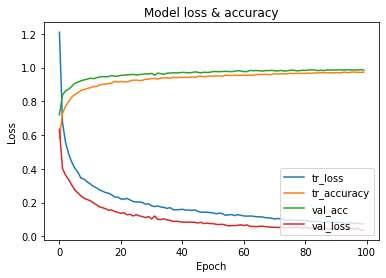

In [64]:
SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
BATCH_SIZE = 512

model = tf.keras.Sequential(name='conv_model_paper')
model.add(tf.keras.layers.InputLayer(input_shape=(1000,1)))
model.add(tf.keras.layers.Conv1D(32,7))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=8))
model.add(tf.keras.layers.Conv1D(48,5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

print(model.summary())
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_dataset, ,epochs=100, validation_data=validation_dataset, verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

### Save the model without optimization and convert it to tflite format

In [7]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()
tflite_model_file = pathlib.Path('conv_model_paper.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvyyw7zyf/assets


INFO:tensorflow:Assets written to: /tmp/tmpvyyw7zyf/assets
2022-10-06 10:32:10.334637: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:32:10.334659: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:32:10.335113: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvyyw7zyf
2022-10-06 10:32:10.336996: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:32:10.337010: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvyyw7zyf
2022-10-06 10:32:10.341964: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-10-06 10:32:10.343512: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-06 10:32:10.389097: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

88160

### Convert the tflite model to a C++ model array

In [8]:
!xxd -i conv_model_paper.tflite > conv_model_paper.cc

### Quantize same model and save it in tflite format.

In [9]:

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('conv_model_paper_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpd_nnl9mk/assets


INFO:tensorflow:Assets written to: /tmp/tmpd_nnl9mk/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-06 10:32:22.149760: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:32:22.149776: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:32:22.149890: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd_nnl9mk
2022-10-06 10:32:22.151344: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:32:22.151359: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd_nnl9mk
2022-10-06 10:32:22.157772: I tensorflow/cc/saved_model/loade

RuntimeError: tensorflow/lite/kernels/conv.cc:350 input->dims->size != 4 (3 != 4)Node number 1 (CONV_2D) failed to prepare.

### Modify Model Described in paper to make it suitable for deployment
     Note that dropout layer and batch normalization layers are removed, because they are not supported by tflite micro.

Model: "final_conv_model_paper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reshape (Reshape)           (None, 1000, 1)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 1000, 32)          256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 125, 32)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 125, 48)           7728      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 32, 48)           0         
 1D)                                                             
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 8, 48) 

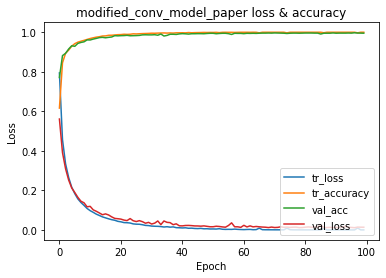

In [65]:
final_conv_model_paper = tf.keras.Sequential(name='final_conv_model_paper')
final_conv_model_paper.add(tf.keras.layers.Reshape((1000,1),name='Reshape', input_shape=(1000,)))
final_conv_model_paper.add(tf.keras.layers.Conv1D(32,7,padding='same',activation='relu'))
final_conv_model_paper.add(tf.keras.layers.MaxPooling1D(8,padding='same'))
final_conv_model_paper.add(tf.keras.layers.Conv1D(48,5,padding='same',activation='relu'))
final_conv_model_paper.add(tf.keras.layers.MaxPooling1D(4,padding='same'))
final_conv_model_paper.add(tf.keras.layers.MaxPooling1D(4,padding='same'))
final_conv_model_paper.add(tf.keras.layers.Flatten())
final_conv_model_paper.add(tf.keras.layers.Dense(32, activation='relu'))
final_conv_model_paper.add(tf.keras.layers.Dense(32, activation='relu'))
final_conv_model_paper.add(tf.keras.layers.Dense(3, activation='softmax'))


print(final_conv_model_paper.summary())
final_conv_model_paper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = final_conv_model_paper.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('modified_conv_model_paper loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating modified_conv_model_paper
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

#### Convert final model to TF-Lite without any optimizations.

In [8]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(final_conv_model_paper)
float_tflite_model = float_converter.convert()
tflite_model_file = pathlib.Path('final_conv_model_paper.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpqfbdgrzs/assets


INFO:tensorflow:Assets written to: /tmp/tmpqfbdgrzs/assets
2022-10-12 11:47:20.160207: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-12 11:47:20.160222: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-12 11:47:20.160298: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqfbdgrzs
2022-10-12 11:47:20.161104: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-12 11:47:20.161114: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqfbdgrzs
2022-10-12 11:47:20.164404: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-12 11:47:20.186333: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqfbdgrzs
2022-10-12 11:47:20.192173: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

14440

### Convert final model to TF-Lite with quantization.

In [7]:

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(final_conv_model_paper)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('final_conv_model_paper_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpfoo48sqn/assets


INFO:tensorflow:Assets written to: /tmp/tmpfoo48sqn/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-12 11:45:53.371003: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-12 11:45:53.371018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-12 11:45:53.371350: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfoo48sqn
2022-10-12 11:45:53.372206: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-12 11:45:53.372221: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfoo48sqn
2022-10-12 11:45:53.375203: I tensorflow/compiler/mlir/mlir_g

11032

### Change the model described in the paper to make it suitable for conversion to TFLite, and quantization.

Model: "conv_modified_conv_model_paper_paper_2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reshape (Reshape)           (None, 1000, 1, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 1000, 1, 32)       1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 1, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 1, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 1, 48)        0         
 2D)                                                             
                                                                 
 max_pooling2d_2 (MaxPoolin

/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2022-10-25 11:40:47.904127: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


  1/329 [..............................] - ETA: 3:53 - loss: 1.0711 - accuracy: 0.4062

2022-10-25 11:40:48.168399: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


329/329 [==============================] - 1s 2ms/step - loss: 0.7741 - accuracy: 0.6649 - val_loss: 0.5540 - val_accuracy: 0.7773
Epoch 2/100
329/329 [==============================] - 1s 2ms/step - loss: 0.4565 - accuracy: 0.8370 - val_loss: 0.3973 - val_accuracy: 0.8604
Epoch 3/100
329/329 [==============================] - 1s 2ms/step - loss: 0.3487 - accuracy: 0.8816 - val_loss: 0.3307 - val_accuracy: 0.8907
Epoch 4/100
329/329 [==============================] - 1s 2ms/step - loss: 0.2920 - accuracy: 0.9062 - val_loss: 0.2799 - val_accuracy: 0.9156
Epoch 5/100
329/329 [==============================] - 1s 2ms/step - loss: 0.2485 - accuracy: 0.9255 - val_loss: 0.2463 - val_accuracy: 0.9258
Epoch 6/100
329/329 [==============================] - 1s 2ms/step - loss: 0.2179 - accuracy: 0.9345 - val_loss: 0.2161 - val_accuracy: 0.9364
Epoch 7/100
329/329 [==============================] - 1s 2ms/step - loss: 0.1929 - accuracy: 0.9434 - val_loss: 0.2041 - val_accuracy: 0.9436
Epoch 8/100

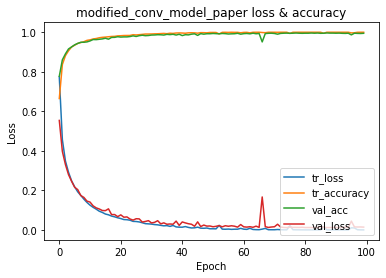

In [19]:
from genericpath import samefile
import tensorflow_model_optimization as tfmot

modified_conv_model_paper = tf.keras.Sequential(name='conv_modified_conv_model_paper_paper_2D')
modified_conv_model_paper.add(tf.keras.layers.Reshape((1000,1,1),name='Reshape', input_shape=(1000,)))
modified_conv_model_paper.add(tf.keras.layers.Conv2D(32,7,padding='same',activation='relu'))
modified_conv_model_paper.add(tf.keras.layers.MaxPooling2D(8,8,padding='same'))
modified_conv_model_paper.add(tf.keras.layers.Conv2D(48,5,padding='same',activation='relu'))
modified_conv_model_paper.add(tf.keras.layers.MaxPooling2D(4,4,padding='same'))
modified_conv_model_paper.add(tf.keras.layers.MaxPooling2D(4,4,padding='same'))
modified_conv_model_paper.add(tf.keras.layers.Flatten())
modified_conv_model_paper.add(tf.keras.layers.Dense(32))
modified_conv_model_paper.add(tf.keras.layers.Dense(32))
modified_conv_model_paper.add(tf.keras.layers.Dense(3, activation='softmax'))


print(modified_conv_model_paper.summary())
modified_conv_model_paper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = modified_conv_model_paper.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('modified_conv_model_paper loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating modified_conv_model_paper
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

In [21]:
from keras_flops import get_flops
flops = get_flops(modified_conv_model_paper)
print(f"FLOPS: {flops} operations")


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

2022-10-25 11:42:34.178972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 11:42:34.179051: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-25 11:42:34.179096: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-10-25 11:42:34.179569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 11:42:34.179648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 11:42:34.179693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] su

In [22]:
print(f"FLOPS: {flops} operations")

FLOPS: 13087618 operations


### Save model as .tflite and .pb

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(modified_conv_model_paper)
modidified_conv_model_converted = converter.convert()
tflite_model_file = pathlib.Path('conv_model_paper_2D.tflite')
tflite_model_file.write_bytes(modidified_conv_model_converted)

INFO:tensorflow:Assets written to: /tmp/tmp4dvj30xg/assets


INFO:tensorflow:Assets written to: /tmp/tmp4dvj30xg/assets
2022-10-06 10:35:25.175786: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:35:25.175803: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:35:25.175888: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4dvj30xg
2022-10-06 10:35:25.176835: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:35:25.176846: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4dvj30xg
2022-10-06 10:35:25.180699: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-06 10:35:25.209889: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4dvj30xg
2022-10-06 10:35:25.216447: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

219920

In [12]:
!xxd -i conv_model_paper_2D.tflite > conv_model_paper_2D.cc

### Quantize same model and save it.

In [13]:

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(modified_conv_model_paper)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('conv_model_paper_2D_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpvsg4qhk4/assets


INFO:tensorflow:Assets written to: /tmp/tmpvsg4qhk4/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-06 10:35:30.343080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:35:30.343097: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:35:30.343211: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvsg4qhk4
2022-10-06 10:35:30.344158: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:35:30.344170: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvsg4qhk4
2022-10-06 10:35:30.347950: I tensorflow/cc/saved_model/loade

62736

In [14]:
!xxd -i conv_model_paper_2D_optimized.tflite > conv_model_paper_2D_optimized.cc

## Define experimental random 2D convolutional model.

Model: "custom_2D_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Reshape (Reshape)           (None, 1000, 1, 1)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1000, 1, 8)        208       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 500, 1, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4000)              0         
                                                                 
 output (Dense)              (None, 3)                 12003     
                                                                 
Total params: 12,211
Trainable params: 12,211
Non-trainable params: 0
__________________________________________

/home/veysiadn/anaconda3/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


375/375 [==============================] - 1s 3ms/step - loss: 0.7049 - accuracy: 0.7482 - val_loss: 0.4442 - val_accuracy: 0.8667
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3371 - accuracy: 0.9085 - val_loss: 0.2578 - val_accuracy: 0.9247
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2221 - accuracy: 0.9372 - val_loss: 0.1939 - val_accuracy: 0.9453
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1728 - accuracy: 0.9488 - val_loss: 0.1598 - val_accuracy: 0.9487
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1443 - accuracy: 0.9561 - val_loss: 0.1403 - val_accuracy: 0.9527
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1235 - accuracy: 0.9635 - val_loss: 0.1253 - val_accuracy: 0.9613
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1079 - accuracy: 0.9682 - val_loss: 0.1172 - val_accuracy: 0.9653
Epoch 8/100

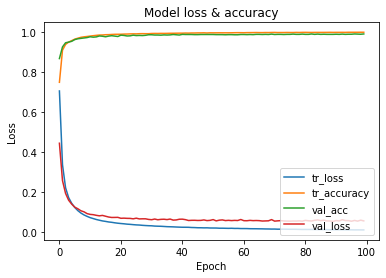

In [15]:
my_custom_model = tf.keras.Sequential(name='custom_2D_conv_model')
my_custom_model.add(tf.keras.Input(shape=(x_train.shape[1],)))
my_custom_model.add(tf.keras.layers.Reshape((1000,1,1),name='Reshape'))
my_custom_model.add(tf.keras.layers.Conv2D(8,5,padding='same',activation='relu'))
my_custom_model.add(tf.keras.layers.MaxPooling2D(2,2, padding='same'))
my_custom_model.add(tf.keras.layers.Flatten())
my_custom_model.add(tf.keras.layers.Dense(3,activation='softmax', name="output"))


print(my_custom_model.summary())
my_custom_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = my_custom_model.fit(x_train, y_train ,epochs=100, validation_data=(x_val, y_val), verbose=1)   


# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])


plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['tr_loss', 'tr_accuracy', 'val_acc', 'val_loss'], loc='lower right')
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")


plt.show()

### Save custom model as .tflite

In [16]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(my_custom_model)
float_tflite_model = float_converter.convert()
tflite_model_file = pathlib.Path('my_custom_model.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8sg93y9j/assets


INFO:tensorflow:Assets written to: /tmp/tmp8sg93y9j/assets
2022-10-06 10:38:28.737573: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:38:28.737590: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:38:28.737673: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8sg93y9j
2022-10-06 10:38:28.738317: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:38:28.738328: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8sg93y9j
2022-10-06 10:38:28.740182: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-06 10:38:28.755834: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8sg93y9j
2022-10-06 10:38:28.760176: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

52432

In [17]:
!xxd -i my_custom_model.tflite > my_custom_model.cc

### Quantize custom model and save it.

In [18]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(my_custom_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('my_custom_model_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpmhz6e2sm/assets


INFO:tensorflow:Assets written to: /tmp/tmpmhz6e2sm/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-06 10:38:43.470713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 10:38:43.470733: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 10:38:43.470829: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmhz6e2sm
2022-10-06 10:38:43.471406: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 10:38:43.471419: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmhz6e2sm
2022-10-06 10:38:43.473459: I tensorflow/cc/saved_model/loade

16712

In [19]:
!xxd -i my_custom_model_optimized.tflite > my_custom_model_optimized.cc

### Quantize model to INT8 and save it.

In [14]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(my_custom_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_file = pathlib.Path('my_custom_model_int8_quant.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmplrt78c1u/assets


INFO:tensorflow:Assets written to: /tmp/tmplrt78c1u/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-06 09:31:25.857597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-06 09:31:25.857611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-06 09:31:25.857717: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplrt78c1u
2022-10-06 09:31:25.858310: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-06 09:31:25.858321: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplrt78c1u
2022-10-06 09:31:25.859923: I tensorflow/cc/saved_model/loade

16704

In [17]:
!xxd -i my_custom_model_int8_quant.tflite > my_custom_model_int8_quant.cc

## Define Dense model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 4004      
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
Total params: 4,019
Trainable params: 4,019
Non-trainable params: 0
_________________________________________________________________
Training results
Training Accuracy: 0.9994285702705383
Training Loss: 0.004588961135596037
Evaluation results
Validation Accuracy: 0.9871110916137695
Validation Loss: 0.07028096914291382


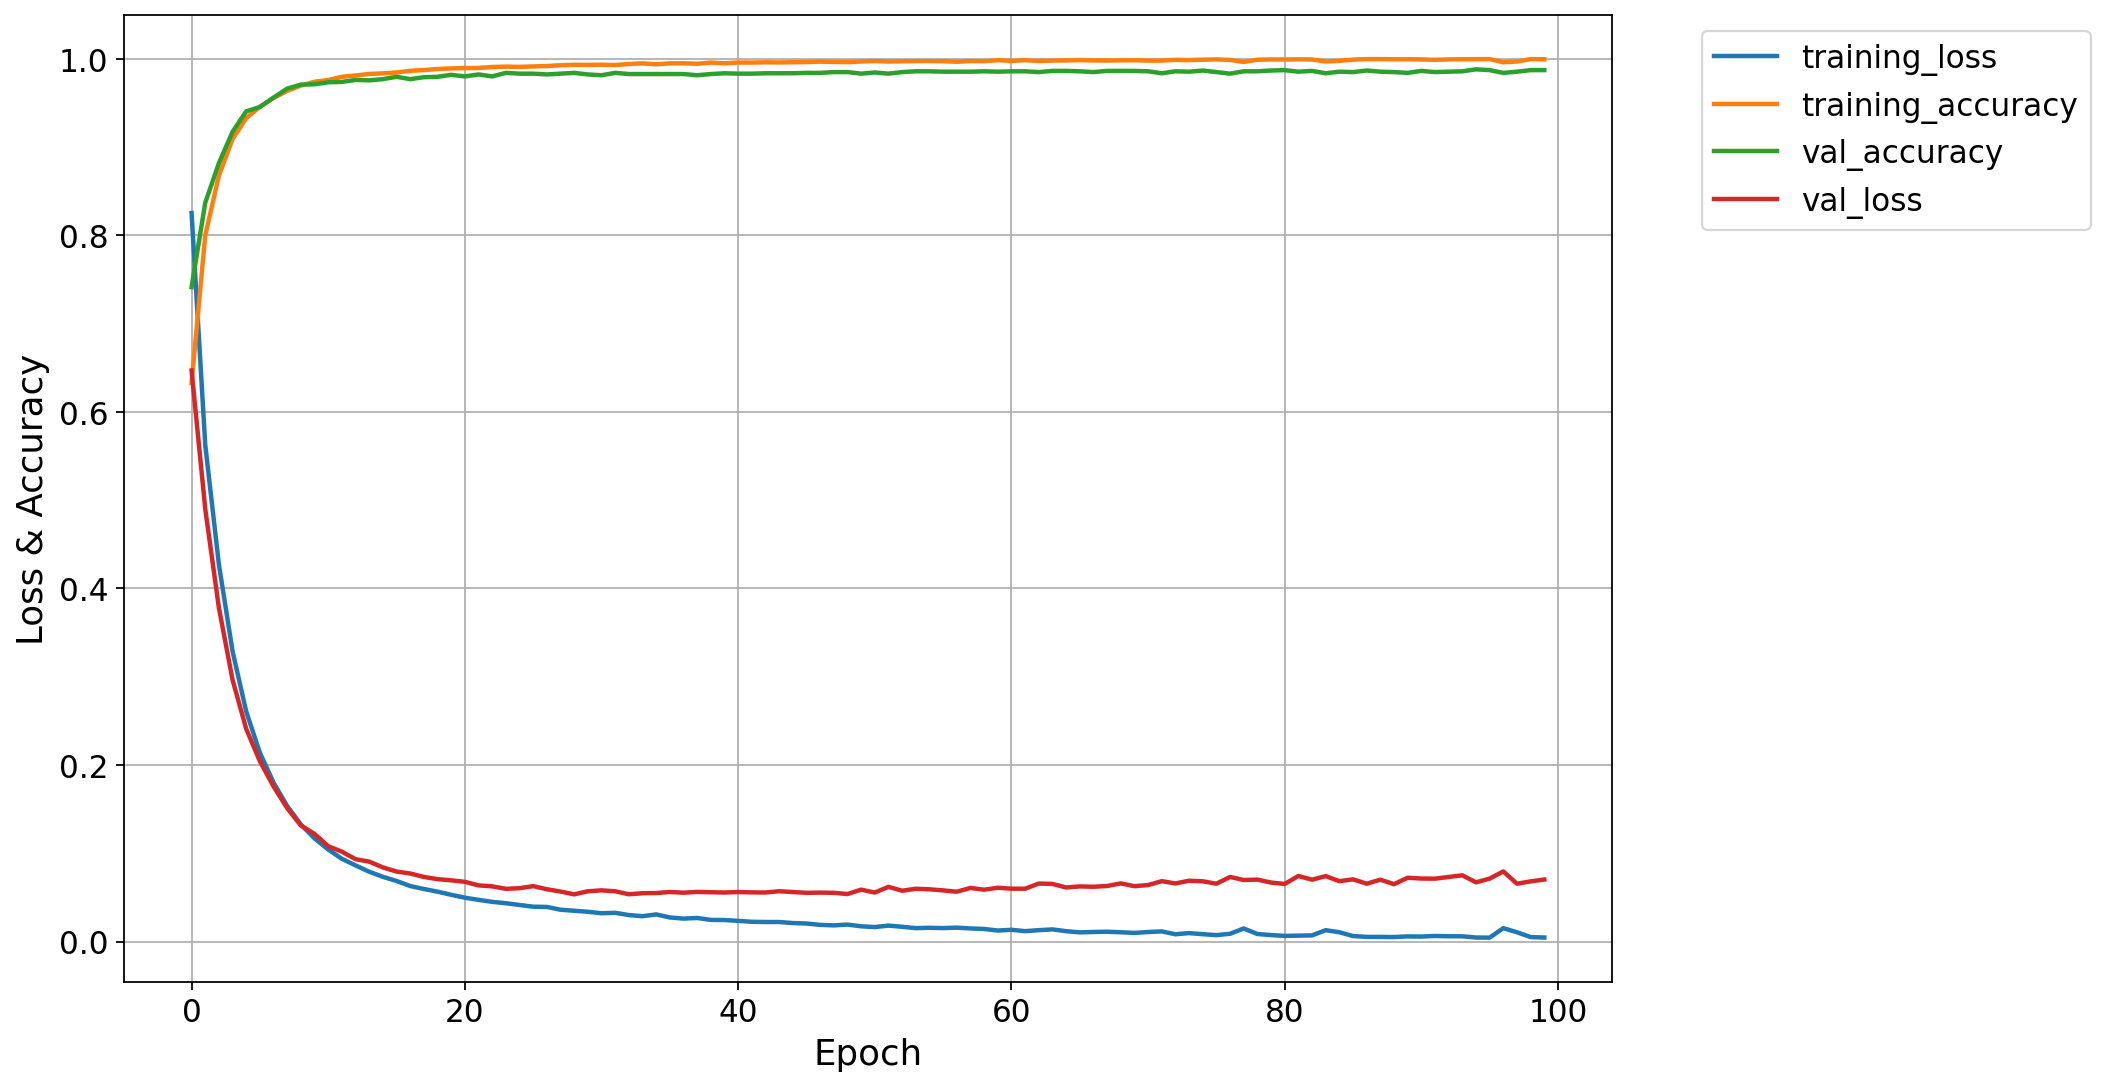

In [3]:
SEED = 99
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.shuffle(buffer_size=256)
                                .batch(BATCH_SIZE)
                                .prefetch(buffer_size=tf.data.AUTOTUNE))

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = (val_dataset.shuffle(buffer_size=256)
                                .batch(BATCH_SIZE)
                                .prefetch(buffer_size=tf.data.AUTOTUNE))

dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='elu',input_shape=(1000,)),
    tf.keras.layers.Dense(3,activation='softmax')
])


dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
dense_model.summary()              

history=dense_model.fit(train_dataset,validation_data=val_dataset, epochs=100,verbose=0)
# dense_model.evaluate(val_dataset)
from tkinter import font
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8),dpi=160)
ax = fig.add_subplot(111)
ax.plot(history.history['loss'], linewidth=2)
ax.plot(history.history['accuracy'],linewidth=2)
ax.plot(history.history['val_accuracy'],linewidth=2)
ax.plot(history.history['val_loss'],linewidth=2)
ax.grid(True)
ax.set_ylabel('Loss & Accuracy', fontsize=16)
ax.set_xlabel('Epoch',fontsize=16)
ax.legend(['training_loss', 'training_accuracy', 'val_accuracy', 'val_loss'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating dense_model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")

plt.show()

### Add plot for paper

Training results
Training Accuracy: 0.9994285702705383
Training Loss: 0.004588961135596037
Evaluation results
Validation Accuracy: 0.9871110916137695
Validation Loss: 0.07028096914291382


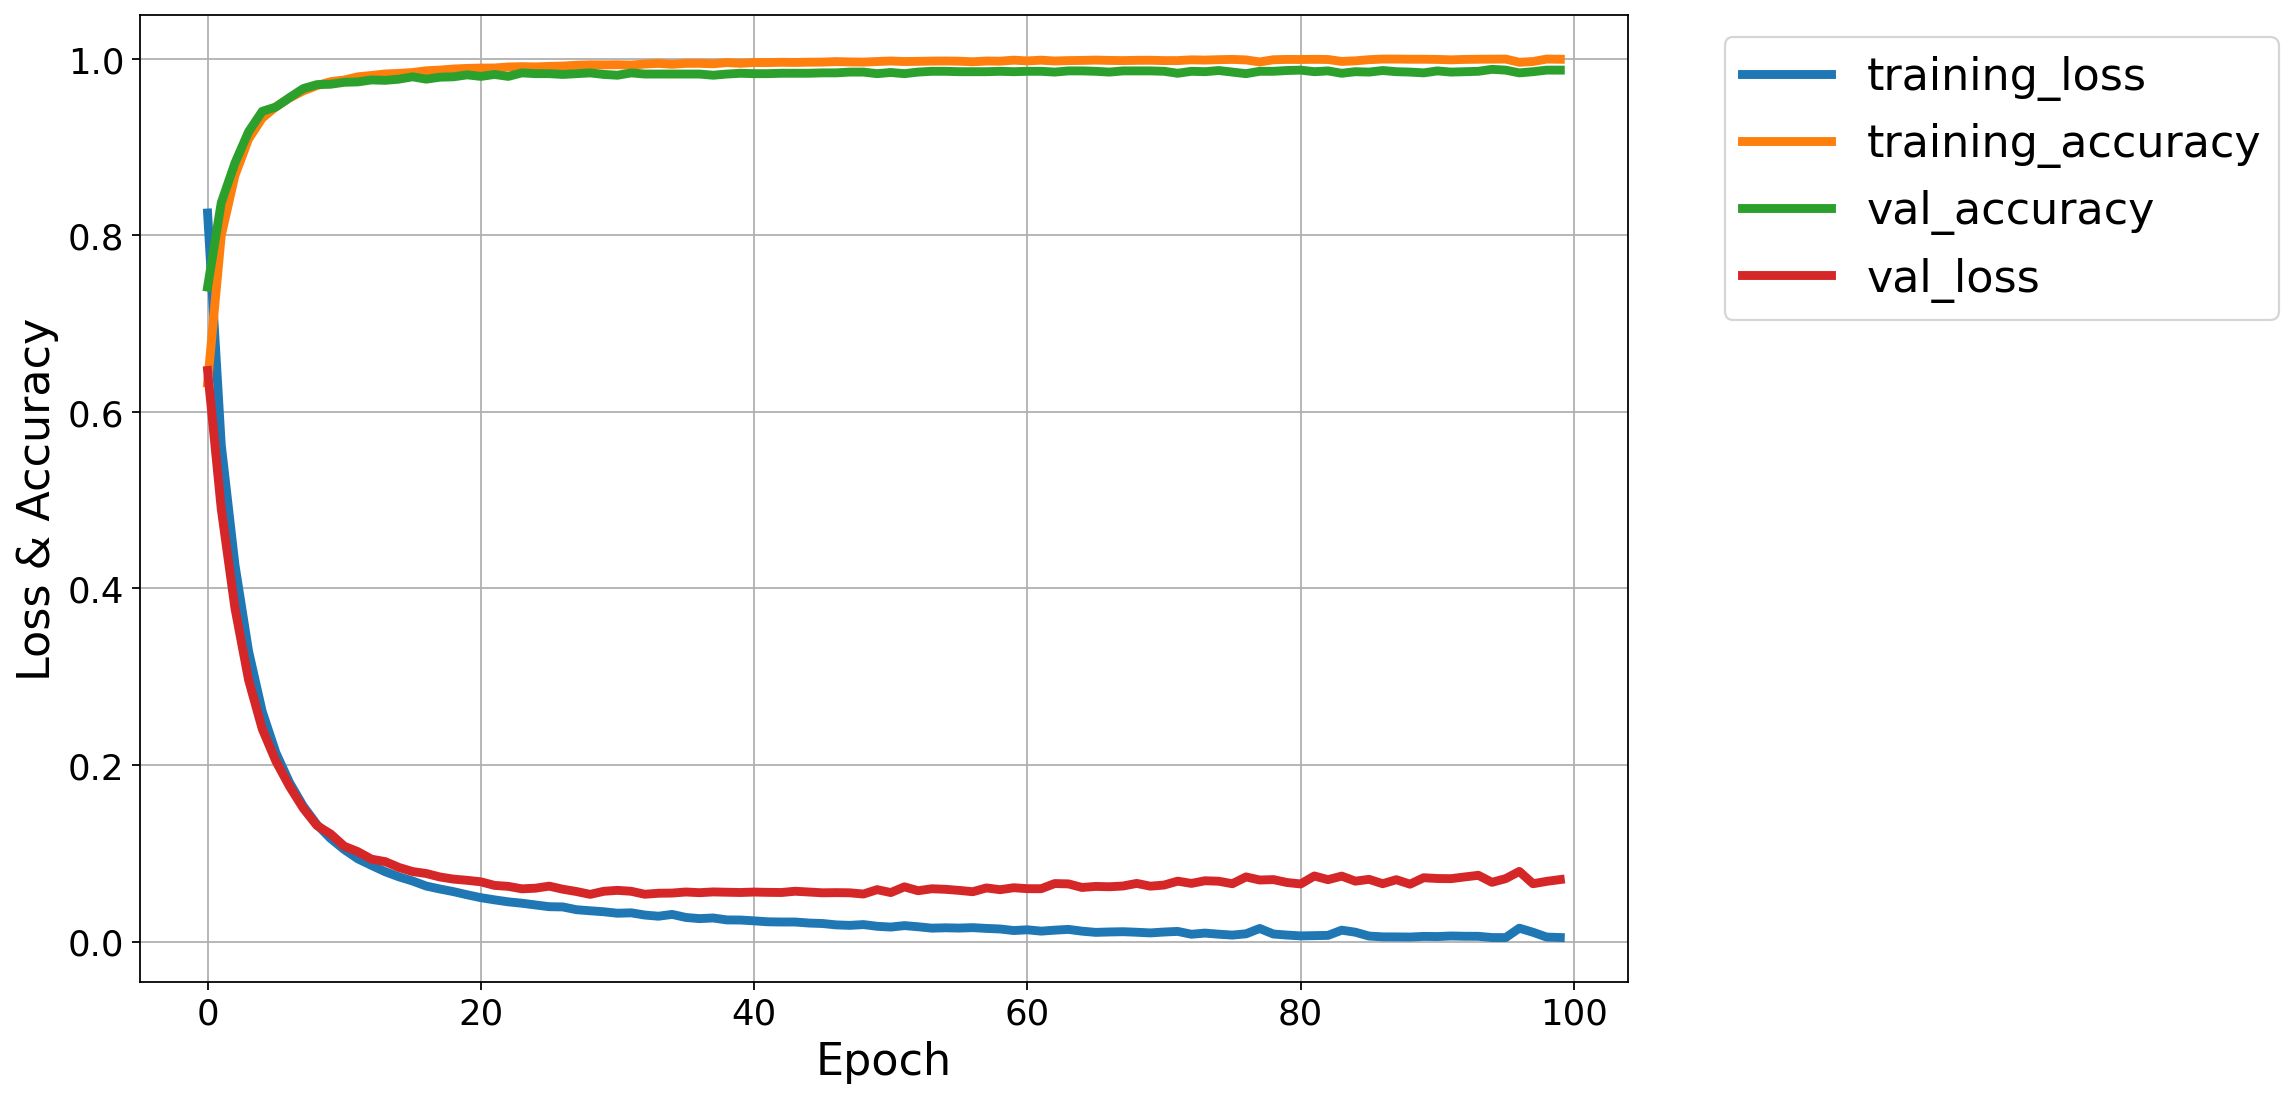

In [8]:
from tkinter import font
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8),dpi=160)
ax = fig.add_subplot(111)
ax.plot(history.history['loss'], linewidth=4)
ax.plot(history.history['accuracy'],linewidth=4)
ax.plot(history.history['val_accuracy'],linewidth=4)
ax.plot(history.history['val_loss'],linewidth=4)
ax.grid(True)
ax.set_ylabel('Loss & Accuracy', fontsize=20)
ax.set_xlabel('Epoch',fontsize=20)
ax.legend(['training_loss', 'training_accuracy', 'val_accuracy', 'val_loss'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# accuracy!
print("Training results")
print(f"Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Training Loss: {history.history['loss'][-1]}")

# evaluating dense_model
print("Evaluation results")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")

plt.show()

In [4]:
dense_model.evaluate(x_test,y_test)

71/71 [==============================] - 0s 1ms/step - loss: 0.0908 - accuracy: 0.9840


[0.09077413380146027, 0.984000027179718]

### Add confusion matrix for paper

71/71 [==============================] - 0s 2ms/step


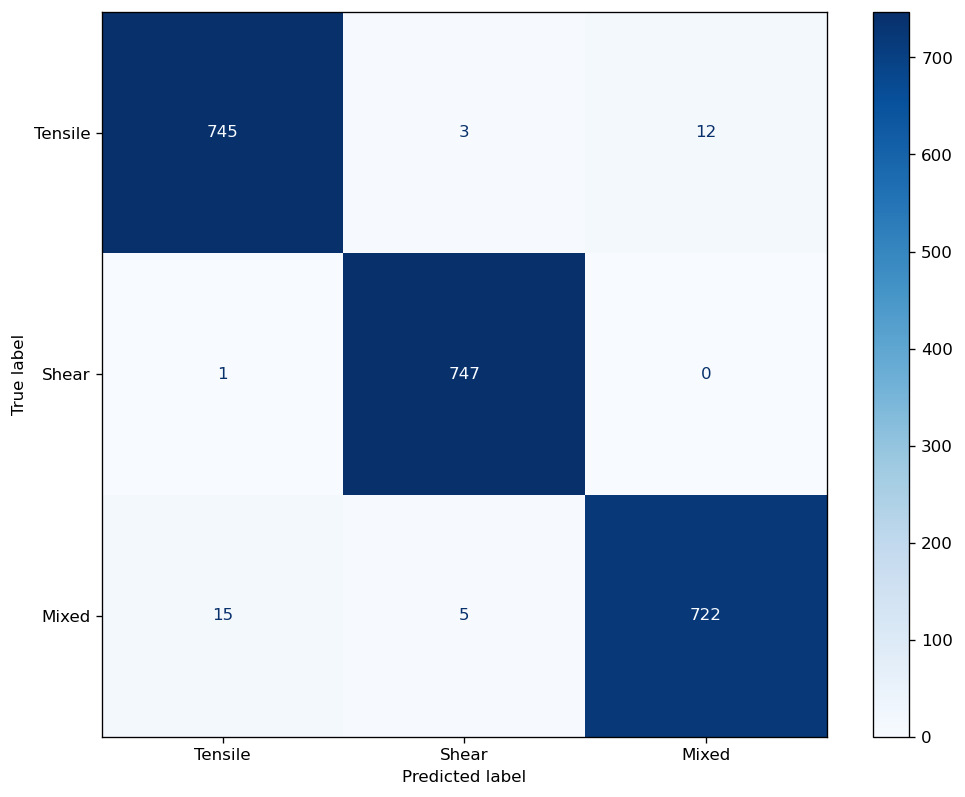

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = dense_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(10, 8), dpi=120)
ax = plt.subplot(111)

cm_display = ConfusionMatrixDisplay(cm,display_labels=['Tensile','Shear', 'Mixed']).plot(ax=ax, cmap=plt.cm.Blues)



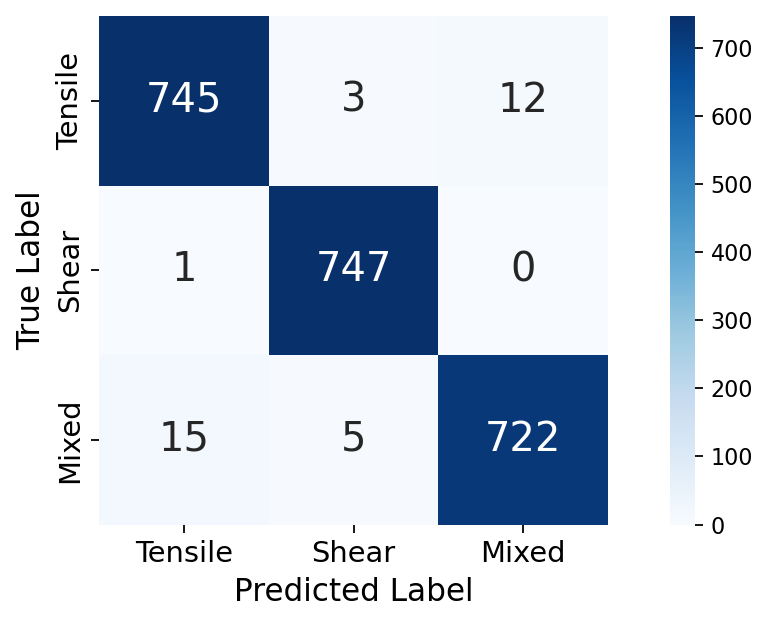

In [55]:
import seaborn as sns
plt.figure(figsize=(8,4), dpi=160)

ax=plt.subplot(111)
# plt.title("Confusion Matrix", fontsize=15)
labels = ['Tensile','Shear', 'Mixed']
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=True, annot_kws={"size": 18},ax=ax, square=True)
ax.set_xticklabels(labels, fontsize=13)
ax.set_yticklabels(labels, fontsize=13)
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)
# ax.patch.set_edgecolor('black')
# ax.patch.set_linewidth('2')
plt.tight_layout()

### ADD F1 score for paper

In [57]:
import sklearn.metrics as metrics

print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred,digits=4))


0.984
              precision    recall  f1-score   support

           0     0.9790    0.9803    0.9796       760
           1     0.9894    0.9987    0.9940       748
           2     0.9837    0.9730    0.9783       742

    accuracy                         0.9840      2250
   macro avg     0.9840    0.9840    0.9840      2250
weighted avg     0.9840    0.9840    0.9840      2250



### Save dense model as tflite - no optimization.

In [33]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(dense_model)
float_tflite_model = float_converter.convert()
import pathlib
tflite_model_file = pathlib.Path('dense_model.tflite')
tflite_model_file.write_bytes(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpi3frmqdo/assets


2022-10-25 11:52:13.634280: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-25 11:52:13.634296: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-25 11:52:13.634723: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi3frmqdo
2022-10-25 11:52:13.635348: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-25 11:52:13.635362: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi3frmqdo
2022-10-25 11:52:13.637202: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-10-25 11:52:13.637745: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-25 11:52:13.656715: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi3frmqdo
2022-10

In [20]:
!xxd -i dense_model.tflite > dense_model.cc

### Quantize dense model and save it as tflite.

In [34]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(dense_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model_quant = converter.convert()

tflite_model_file = pathlib.Path('dense_model_optimized.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmp42_dbpil/assets


INFO:tensorflow:Assets written to: /tmp/tmp42_dbpil/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-10-25 11:52:21.904683: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-25 11:52:21.904698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-25 11:52:21.904785: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp42_dbpil
2022-10-25 11:52:21.905752: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-25 11:52:21.905765: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp42_dbpil
2022-10-25 11:52:21.909146: I tensorflow/cc/saved_model/loade

In [22]:
!xxd -i dense_model_optimized.tflite > dense_model_optimized.cc

## Run TF-Lite Interpreter 

In [23]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, indices):
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = 0
  for i, index in enumerate(indices):
    test_data = x_test[index]
    test_data=np.expand_dims(test_data, axis=0)
    test_labels = y_train[index]

    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    print(output[0])
    print(output[1])
    print(output[2])
    predictions = output.argmax()

  return predictions

In [24]:
import matplotlib.pylab as plt
tflite_model_file = 'dense_model.tflite'
# Change this to test a different image
indice = 333

## Helper function to test the models on one image
def test_model(tflite_file, indice, model_type):

  predictions = run_tflite_model(tflite_file, [indice])

  print(f" Model \n True:{y_test[indice]}, Predicted:{predictions}")
  
test_model(tflite_model_file, indice, model_type="Float")

8.737704e-08
0.00016263525
0.99983716
 Model 
 True:[2], Predicted:2


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path='float_model.tflite')

In [25]:
import numpy as np

def run_tflite_model_for_eval(interpreter, indices):
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = 0
  for i, index in enumerate(indices):
    test_data = x_test[index]
    test_data=np.expand_dims(test_data, axis=0)

    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    predictions = output.argmax()
  return predictions
  
def evaluate_model(interpreter):
  output_predictions =[]
  for i in range(len(x_test)):
    output_predictions.append(run_tflite_model_for_eval(interpreter,[i]))
  output_predictions = np.array(output_predictions)
  output_predictions = np.expand_dims(output_predictions, axis=1)
  accuracy = (output_predictions == y_test).mean()
  return accuracy

In [21]:
interpreter = tf.lite.Interpreter(model_path='dense_model_optimized.tflite')
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Optimized dense_model TFLite test_accuracy:', test_accuracy)


Optimized dense_model TFLite test_accuracy: 0.9826666666666667


## MLTK Library for profiling the tflite models.
    It is really useful for calculating number of operations, required memory, CPU cycle etc.

In [6]:
# Import the standard Python packages used by the examples
import os
import urllib
import shutil
import tempfile

# Import the necessary MLTK APIs
from mltk.core import profile_model
from mltk.utils.commander import query_platform

### Optimized dense model profiling

In [7]:
tflite_path = './dense_model_optimized.tflite'

# Profile the tflite model using the "basic simulator"
# NOTE: Update tflite_path to point to your model if necessary
profiling_results = profile_model(tflite_path)

# Print the profiling results
print(profiling_results)

Profiling Summary
Name: dense_model_optimized
Accelerator: None
Input Shape: 1x1000
Input Data Type: float32
Output Shape: 1x3
Output Data Type: float32
Flash, Model File Size (bytes): 7.0k
RAM, Runtime Memory Size (bytes): 6.6k
Operation Count: 12.1k
Multiply-Accumulate Count: 4.0k
Layer Count: 9
Unsupported Layer Count: 0
CPU Cycle Count: 71.2k
CPU Utilization (%): 0.0
Clock Rate (hz): 78.0M
Energy (J): 1.3u
J/Op: 105.3p
J/MAC: 317.1p

Model Layers
+-------+-----------------+-------+--------+------------+------------+-----------------+--------------+---------------------+
| Index | OpCode          | # Ops | # MACs | CPU Cycles | Energy (J) | Input Shape     | Output Shape | Options             |
+-------+-----------------+-------+--------+------------+------------+-----------------+--------------+---------------------+
| 0     | quantize        | 4.0k  | 0      | 36.7k      | 422.4n     | 1x1000          | 1x1000       | Type=none           |
| 1     | reshape         | 0     | 0    

### Dense Model Profiling

In [46]:
tflite_path = './dense_model.tflite'

# Profile the tflite model using the "basic simulator"
# NOTE: Update tflite_path to point to your model if necessary
profiling_results = profile_model(tflite_path)

# Print the profiling results
print(profiling_results)

Profiling Summary
Name: dense_model
Accelerator: None
Input Shape: 1x1000
Input Data Type: float32
Output Shape: 1x3
Output Data Type: float32
Flash, Model File Size (bytes): 18.2k
RAM, Runtime Memory Size (bytes): 9.3k
Operation Count: 8.0k
Multiply-Accumulate Count: 4.0k
Layer Count: 5
Unsupported Layer Count: 0
CPU Cycle Count: 19.8k
CPU Utilization (%): 0.0
Clock Rate (hz): 78.0M
Energy (J): 109.2n
J/Op: 13.6p
J/MAC: 27.2p

Model Layers
+-------+-----------------+-------+--------+------------+------------+-----------------+--------------+---------------------+
| Index | OpCode          | # Ops | # MACs | CPU Cycles | Energy (J) | Input Shape     | Output Shape | Options             |
+-------+-----------------+-------+--------+------------+------------+-----------------+--------------+---------------------+
| 0     | reshape         | 0     | 0      | 234.4      | 0.0p       | 1x1000,2        | 1x1000       | Type=none           |
| 1     | fully_connected | 8.0k  | 4.0k   | 14.6k 

### Conv Model Paper Modified for Deployment Profiling

In [8]:
tflite_path = './conv_model_paper_2D.tflite'

profiling_results = profile_model(tflite_path)

# Print the profiling results
print(profiling_results)

Profiling Summary
Name: conv_model_paper_2D
Accelerator: None
Input Shape: 1x1000
Input Data Type: float32
Output Shape: 1x3
Output Data Type: float32
Flash, Model File Size (bytes): 219.9k
RAM, Runtime Memory Size (bytes): 146.8k
Operation Count: 13.2M
Multiply-Accumulate Count: 6.4M
Layer Count: 14
Unsupported Layer Count: 0
CPU Cycle Count: 39.1M
CPU Utilization (%): 0.0
Clock Rate (hz): 78.0M
Energy (J): 7.8m
J/Op: 592.0p
J/MAC: 1.2n

Model Layers
+-------+-----------------+--------+--------+------------+------------+-------------------------+--------------+----------------------------------------------------+
| Index | OpCode          | # Ops  | # MACs | CPU Cycles | Energy (J) | Input Shape             | Output Shape | Options                                            |
+-------+-----------------+--------+--------+------------+------------+-------------------------+--------------+----------------------------------------------------+
| 0     | shape           | 0      | 0      | 

### Convolutional Model Paper Quantized Profiling

In [9]:
tflite_path = './conv_model_paper_2D_optimized.tflite'

profiling_results = profile_model(tflite_path)

# Print the profiling results
print(profiling_results)

Profiling Summary
Name: conv_model_paper_2D_optimized
Accelerator: None
Input Shape: 1x1000
Input Data Type: float32
Output Shape: 1x3
Output Data Type: float32
Flash, Model File Size (bytes): 62.7k
RAM, Runtime Memory Size (bytes): 39.1k
Operation Count: 13.2M
Multiply-Accumulate Count: 6.4M
Layer Count: 16
Unsupported Layer Count: 0
CPU Cycle Count: 39.1M
CPU Utilization (%): 0.0
Clock Rate (hz): 78.0M
Energy (J): 7.8m
J/Op: 591.9p
J/MAC: 1.2n

Model Layers
+-------+-----------------+--------+--------+------------+------------+-------------------------+--------------+----------------------------------------------------+
| Index | OpCode          | # Ops  | # MACs | CPU Cycles | Energy (J) | Input Shape             | Output Shape | Options                                            |
+-------+-----------------+--------+--------+------------+------------+-------------------------+--------------+----------------------------------------------------+
| 0     | quantize        | 4.0k   | 0